# Convolution Neural Net (CNN)
to detect apples

# Imports

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import modules.cosmos_functions as cf

import pprint
import random
import torch
import torchvision
import torch.nn.functional as F

import torchvision.transforms as T
import wandb
import torch.optim as optim
from datetime import datetime
from os import listdir, path
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision.io import ImageReadMode
from torchvision.io import read_image
from tqdm import tqdm

from torchvision import models
from torchvision.models import resnet18, ResNet18_Weights

In [14]:
# set the device

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
x = torch.ones(1, device=device)

print(f"Device is '{device}' Thus a tensor will look like this: {x}")

Device is 'mps' Thus a tensor will look like this: tensor([1.], device='mps:0')


In [15]:
# function to show the images

def reverse_normalize(image):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = image.clone()
    for i in range(3):
        image[i] = (image[i] * std[i]) + mean[i]
    return image


def show_batch(train_d, val_d):
    # Get a batch of data from the DataLoader
    data_train = next(iter(train_d))
    data_val = next(iter(val_d))

    # Set the savefig.bbox parameter to 'tight'
    plt.rcParams["savefig.bbox"] = 'tight'

    # Retrieve the first tensor and its corresponding label
    image_train = data_train[0][0]
    # image_test = data_test[0][0]
    image_val = data_val[0][0]
    label_train = data_train[1][0]
    # label_test = data_test[1][0]
    label_val = data_val[1][0]

    # Reverse the normalization of the images
    image_train = reverse_normalize(image_train)
    # image_test = reverse_normalize(image_test)
    image_val = reverse_normalize(image_val)

    # Convert the image tensors to NumPy arrays and transpose the dimensions
    np_image_train = image_train.permute(1, 2, 0).numpy()
    # np_image_test = image_test.permute(1, 2, 0).numpy()
    np_image_val = image_val.permute(1, 2, 0).numpy()

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 2)

    # Display the image in the first subplot
    axes[0].imshow(np_image_train)
    axes[0].set_title(f'{label_train}, {image_train.shape}')

    # Display the image in the third subplot
    axes[1].imshow(np_image_val)
    axes[1].set_title(f'{label_val}, {image_val.shape}')

    # # Display the image in the second subplot
    # axes[2].imshow(np_image_test)
    # axes[2].set_title(f'{label_test}, {image_test.shape}')

    # Adjust spacing between subplots to prevent overlap
    fig.tight_layout()

    # Show the plot
    plt.show()


In [16]:
# function to determine accuracy 

def evaluate_accuracy(logits, y_true):
    # get index with the largest logit value PER OBSERVATION
    _, y_pred = torch.max(logits, dim=1)

    # calculate proportion of correct prediction
    correct_pred = (y_pred == y_true).float()  # PyCharm error Unresolved attribute reference 'float' for class 'bool'
    acc = correct_pred.sum() / len(correct_pred)

    return acc * 100

In [17]:
# function to train the model

def train(model, train_loader, val_loader, criterion, optimizer, n_epochs, model_file_name='model.pt',local_save_path='storage/data/generated'):
    # initialize container variable for model performance results per epoch
    history = {
        'n_epochs': n_epochs,
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }   

    # initialize tracker for minimum validation loss and maxiumum validation accuracy
    val_loss_min = np.Inf
    val_loss_epoch = 0
    val_acc_max = 0.0
    val_acc_epoch = 0
    best_results = {
        'val_loss_min': val_loss_min,
        'val_loss_epoch': val_loss_epoch,
        'val_acc_max': val_acc_max,
        'val_acc_epoch': val_acc_epoch
        }    

    model_file_name_loss = f'{str(model_file_name[:-3])}_loss.pt'
    model_file_name_acc = f'{str(model_file_name[:-3])}_acc.pt'
    final_model_file_name = f'{str(model_file_name[:-3])}_final.pt'
    locally_saved_path = local_save_path   

    file_data = { 
                'local_save_path' : locally_saved_path,
                'min_loss_file' : model_file_name_loss,
                'max_acc_file' : model_file_name_acc,
                'final_epoch_file' : final_model_file_name
                  }
    
    early_stopping_counter = 0

    model_safe_loss = f'../{locally_saved_path}/{model_file_name_loss}'
    model_safe_acc = f'../{locally_saved_path}/{model_file_name_acc}'
    model_safe_final = f'../{locally_saved_path}/{final_model_file_name}'

    # loop per epoch
    for epoch in tqdm(range(n_epochs)):
        
        # initialize tracker for training performance
        train_acc = 0
        train_loss = 0

        ###################
        # train the model #
        ###################

        # prepare model for training
        model.train()

        # loop for each batch
        for data, target in train_loader:
            # move data to device
            data, target = data.to(device), target.to(device)
            
            # STEP 1: clear gradients
            optimizer.zero_grad()
            # STEP 2: forward pass
            output = model(data)
            # STEP 3: calculate the loss
            loss = criterion(output, target)
            # STEP 4: backward pass
            loss.backward()
            # STEP 5: perform parameter update
            optimizer.step()
            # STEP 6: accumulate training loss and accuracy
            train_loss += loss.item() * data.size(0)
            acc = evaluate_accuracy(output, target)
            train_acc += acc.item() * data.size(0)

        ######################
        # validate the model #
        ######################

        # disable gradient calculation
        with torch.no_grad():
            # initialize tracker for validation performance
            val_acc = 0
            val_loss = 0

            # prepare model for evaluation
            model.eval()

            # loop for each batch
            for data, target in val_loader:
                # move data to device
                data, target = data.to(device), target.to(device)
                # STEP 1: forward pass
                output = model(data)
                # STEP 2: calculate the loss
                loss = criterion(output, target)
                # STEP 3: accumulate validation loss and accuracy
                val_loss += loss.item() * data.size(0)
                acc = evaluate_accuracy(output, target)
                val_acc += acc.item() * data.size(0)


        ####################
        # model evaluation #
        ####################

        # calculate average loss over an epoch
        train_loss /= len(train_loader.sampler)
        val_loss /= len(val_loader.sampler)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # calculate average accuracy over an epoch
        train_acc /= len(train_loader.sampler)
        val_acc /= len(val_loader.sampler)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # print training progress per epoch
        print(f'Epoch {epoch+1:03} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}')

        # save model if validation loss has decreased
        if val_loss <= val_loss_min:
            print(
                f'Validation loss decreased ({val_loss_min:.5f} --> {val_loss:.5f})  Saving model to {model_file_name}...')
            

            torch.save(model, model_safe_loss)
            val_loss_min = val_loss
            best_results['val_loss_min'] = val_loss_min
            best_results['val_loss_epoch'] = epoch+1
            early_stopping_counter = 0
        
        
        # save model if validation accuracy has decreased
        if val_acc >= val_acc_max:
            print(
                f'Validation accuracy increased ({val_acc_max:.5f} --> {val_acc:.5f})  Saving model to {model_file_name}...')
            
            torch.save(model, model_safe_acc)
            val_acc_max = val_acc
            best_results['val_acc_max'] = val_acc_max
            best_results['val_acc_epoch'] = epoch+1
        
        early_stopping_counter += 1
        if early_stopping_counter >= 3 and val_loss <= 0.1:
            print(f'Early stopping at epoch {epoch+1} as loss has not increased for 5 epochs and is lower than 1')
            break

        # log metrics to wandb
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_acc": train_acc, "val_acc": val_acc})

    # save model at the end of training    
    torch.save(model, model_safe_final)

    results = best_results, history, file_data
    
    # return model performance history
    return results

In [18]:
# load the dataset
dataset_path = "../storage/images/apple_extended_unedited/Train/"
# transform and normalize the data
transform = T.Compose([
    T.ToTensor(),
    T.transforms.Resize((256, 256)),
    T.transforms.RandomCrop((224, 224)),
    T.transforms.RandomHorizontalFlip(),
    T.transforms.RandomVerticalFlip(),
    # T.transforms.RandomRotation(25),  # Randomly rotate the image by a maximum of 30 degrees
    # T.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Slightly change the image color
    # T.transforms.RandomGrayscale(p=0.1),  # Randomly convert the image to grayscale with a probability of 10%
    # T.transforms.RandomErasing(p=0.1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),  # Randomly erase rectangular patches of the image with a probability of 10%
    # # T.transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3),  # Randomly apply a perspective transformation to the image with a probability of 10%
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(dataset_path, transform=transform)


dataset.class_to_idx
pp = pprint.PrettyPrinter(indent=1)  # Create a PrettyPrinter instance with an indentation of 1 space
pp.pprint(dataset.class_to_idx)  # Use the pprint method to print the dictionary



{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}


torch.Size([3, 224, 224])
281
121


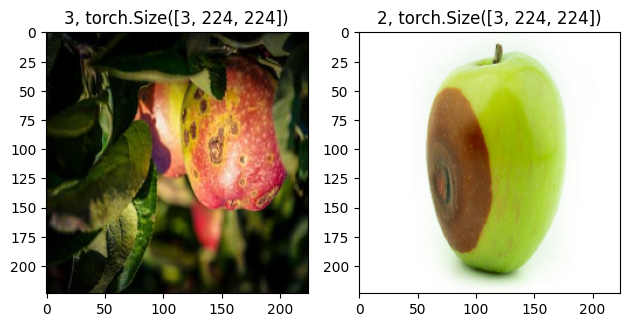

tensor([[[-1.8352, -1.6489, -1.6583,  ..., -0.8996, -0.9500, -1.0916],
         [-2.0262, -1.8040, -1.6013,  ..., -0.7979, -0.9617, -1.0997],
         [-2.0308, -1.9371, -1.7314,  ..., -0.7192, -0.9576, -1.0016],
         ...,
         [-1.7649, -1.8180, -1.8734,  ..., -1.1218, -1.0552, -1.0285],
         [-1.7943, -1.8124, -1.8782,  ..., -1.3786, -1.3455, -1.2934],
         [-1.8005, -1.8480, -1.8996,  ..., -1.5870, -1.5548, -1.4775]],

        [[-1.3090, -1.1360, -1.1457,  ..., -0.1600, -0.2640, -0.4963],
         [-1.5043, -1.3821, -1.1750,  ...,  0.0141, -0.1709, -0.4258],
         [-1.5584, -1.5105, -1.3003,  ...,  0.0945, -0.1682, -0.3279],
         ...,
         [-1.4297, -1.5540, -1.7150,  ..., -0.7022, -0.6342, -0.6419],
         [-1.5271, -1.6524, -1.7687,  ..., -0.9823, -0.9484, -0.9477],
         [-1.6237, -1.7248, -1.8519,  ..., -1.2829, -1.2499, -1.2059]],

        [[-1.4644, -1.2922, -1.3018,  ..., -0.7737, -0.8598, -0.9865],
         [-1.6589, -1.5024, -1.2961,  ..., -0

In [19]:
# create the test, train and validation set and the dataloader

# setup split data 
dataset_size = len(dataset)
train_ratio = 0.7
val_ratio = 0.3



# Set the seed for the generator
seed = 42
generator = torch.Generator().manual_seed(seed)

# Calculate the number of samples for each split
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size 


# Split the dataset into train, validation, and test sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)


# Define the batch size for the DataLoader
batch_size = 32

# Create the DataLoader to load the dataset in batches
train_d = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # num_workers uitzoeken of het zin heeft met MPS
val_d = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# print the shape of the 1st image in the dataset
print(train_dataset[0][0].shape)
print(len(train_dataset))
print(len(val_dataset))
# Show the 1st img in the dataset
show_batch(train_d, val_d)
print(train_dataset[0][0])
# Get the values of the middle 4x4 pixels of the 1st image in the dataset
print(train_dataset[0][0][:, 112:116, 112:116])

In [20]:
# import the resnet18 model

model = torch.hub.load(
    "pytorch/vision", "resnet18", weights="IMAGENET1K_V1")
num_ftrs = model.fc.in_features

# Here the size of each output sample is set to 4
model.fc = nn.Linear(num_ftrs, 4)

# Check if output size is correct
model.eval()


Using cache found in /Users/stephandekker/.cache/torch/hub/pytorch_vision_main


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# set the hyperparameters and the model

# hyperparameters
learning_rate = 0.001
epochs = 50
betas = None  # (0.9, 0.999)
momentum = 0.1
dropout = 0.1
total_epochs = 0  # legacy code
optchoice = 'adam'  # 'sgd' or 'adam'

# model parameters

# model = CNN(dropout=dropout) # Create the model
model.to(device) # set model to device

model.train() # set model to train mode

# optimizer
import torch.optim as optim
CrossEntropyLossCriterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(myresnetmodel.parameters(), lr=mylearnrate, momentum=mymomentum)
if optchoice == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print('optimizer = Adam')
elif optchoice  == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    print('optimizer = sgd')

# loss function
criterion = nn.CrossEntropyLoss()   # Define the loss function  
 
 # set the loaders to the correct names for the training loop
train_loader = train_d
val_loader = val_d

# set epochloss to empty list
epoch_loss = []
# create dictionairies for the hyperparameters and model parameters

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
userAccountID = cf.settings['userAccountID']
saveFileName = f'{timestamp}_{userAccountID}.pt'

hyperparameters = { 'saveFileName': saveFileName, 'learning_rate' : learning_rate, 'epochs' : epochs, 'momentum' : momentum, 'betas' : betas, 'dropout' : dropout}
model_parameters = { 'model' : 'resnet18', 'optimizer' : optchoice, 'criterion' : 'CrossEntropyLoss'}  # 'model' : model, 'optimizer' : optimizer, 'criterion' : criterion
parameters = {**hyperparameters, **model_parameters}    # merge the two dictionairies
pp = pprint.PrettyPrinter(indent=1)  


pp.pprint(f'parameters: {parameters}')
# the training loop


# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="resnet18_224x224_tests",
    
    # track hyperparameters and run metadata
    config= parameters
)

history = train(
    model, train_loader, val_loader, criterion, optimizer, n_epochs=epochs,
    model_file_name=saveFileName
)

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

print()
print(f'best results: {history[0]}')
print()
print(f'alot is: {history[1]}')
print()
print(f'save path = {history[2]}')

optimizer = Adam
("parameters: {'saveFileName': '20230613-153713_pinky.pt', 'learning_rate': "
 "0.001, 'epochs': 50, 'momentum': 0.1, 'betas': None, 'dropout': 0.1, "
 "'model': 'resnet18', 'optimizer': 'adam', 'criterion': 'CrossEntropyLoss'}")


  0%|          | 0/50 [00:00<?, ?it/s]/Users/stephandekker/.local/share/virtualenvs/pink_lady-bMzUwwsu/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 001 | Train Loss: 0.71440 | Val Loss: 5.77929 | Train Acc: 72.95 | Val Acc: 54.55
Validation loss decreased (inf --> 5.77929)  Saving model to 20230613-153713_pinky.pt...
Validation accuracy increased (0.00000 --> 54.54545)  Saving model to 20230613-153713_pinky.pt...


  4%|▍         | 2/50 [00:14<05:55,  7.41s/it]

Epoch 002 | Train Loss: 0.61619 | Val Loss: 1.54194 | Train Acc: 81.85 | Val Acc: 66.94
Validation loss decreased (5.77929 --> 1.54194)  Saving model to 20230613-153713_pinky.pt...
Validation accuracy increased (54.54545 --> 66.94215)  Saving model to 20230613-153713_pinky.pt...


  6%|▌         | 3/50 [00:21<05:38,  7.19s/it]

Epoch 003 | Train Loss: 0.57322 | Val Loss: 7.04030 | Train Acc: 84.70 | Val Acc: 57.02


  8%|▊         | 4/50 [00:28<05:26,  7.10s/it]

Epoch 004 | Train Loss: 0.38831 | Val Loss: 2.06317 | Train Acc: 86.48 | Val Acc: 61.98


 10%|█         | 5/50 [00:35<05:19,  7.10s/it]

Epoch 005 | Train Loss: 0.20972 | Val Loss: 0.54693 | Train Acc: 92.53 | Val Acc: 80.17
Validation loss decreased (1.54194 --> 0.54693)  Saving model to 20230613-153713_pinky.pt...
Validation accuracy increased (66.94215 --> 80.16529)  Saving model to 20230613-153713_pinky.pt...


 12%|█▏        | 6/50 [00:42<05:11,  7.08s/it]

Epoch 006 | Train Loss: 0.15946 | Val Loss: 1.16451 | Train Acc: 95.02 | Val Acc: 77.69


 14%|█▍        | 7/50 [00:50<05:04,  7.08s/it]

Epoch 007 | Train Loss: 0.17398 | Val Loss: 0.51864 | Train Acc: 92.88 | Val Acc: 87.60
Validation loss decreased (0.54693 --> 0.51864)  Saving model to 20230613-153713_pinky.pt...
Validation accuracy increased (80.16529 --> 87.60331)  Saving model to 20230613-153713_pinky.pt...


 16%|█▌        | 8/50 [00:56<04:55,  7.04s/it]

Epoch 008 | Train Loss: 0.15141 | Val Loss: 0.56683 | Train Acc: 93.24 | Val Acc: 85.12


 18%|█▊        | 9/50 [01:03<04:47,  7.01s/it]

Epoch 009 | Train Loss: 0.08720 | Val Loss: 0.72973 | Train Acc: 96.80 | Val Acc: 81.82


 20%|██        | 10/50 [01:10<04:39,  6.98s/it]

Epoch 010 | Train Loss: 0.15136 | Val Loss: 0.81455 | Train Acc: 94.66 | Val Acc: 79.34


 22%|██▏       | 11/50 [01:17<04:32,  6.98s/it]

Epoch 011 | Train Loss: 0.09852 | Val Loss: 0.67875 | Train Acc: 96.44 | Val Acc: 77.69


 24%|██▍       | 12/50 [01:24<04:24,  6.97s/it]

Epoch 012 | Train Loss: 0.18637 | Val Loss: 0.52469 | Train Acc: 94.66 | Val Acc: 85.95


 26%|██▌       | 13/50 [01:31<04:17,  6.95s/it]

Epoch 013 | Train Loss: 0.07484 | Val Loss: 0.59420 | Train Acc: 98.22 | Val Acc: 84.30


 28%|██▊       | 14/50 [01:38<04:09,  6.94s/it]

Epoch 014 | Train Loss: 0.08972 | Val Loss: 0.90150 | Train Acc: 97.15 | Val Acc: 76.03


 30%|███       | 15/50 [01:45<04:03,  6.95s/it]

Epoch 015 | Train Loss: 0.07179 | Val Loss: 0.78278 | Train Acc: 96.44 | Val Acc: 81.82


 32%|███▏      | 16/50 [01:52<03:57,  6.97s/it]

Epoch 016 | Train Loss: 0.20443 | Val Loss: 0.50004 | Train Acc: 93.24 | Val Acc: 84.30
Validation loss decreased (0.51864 --> 0.50004)  Saving model to 20230613-153713_pinky.pt...


 34%|███▍      | 17/50 [01:59<03:49,  6.96s/it]

Epoch 017 | Train Loss: 0.26855 | Val Loss: 4.07234 | Train Acc: 91.46 | Val Acc: 62.81


 36%|███▌      | 18/50 [02:06<03:42,  6.96s/it]

Epoch 018 | Train Loss: 0.34595 | Val Loss: 2.88765 | Train Acc: 90.39 | Val Acc: 52.89


 38%|███▊      | 19/50 [02:13<03:36,  6.97s/it]

Epoch 019 | Train Loss: 0.28596 | Val Loss: 0.95138 | Train Acc: 92.17 | Val Acc: 73.55


 40%|████      | 20/50 [02:20<03:29,  6.97s/it]

Epoch 020 | Train Loss: 0.22009 | Val Loss: 0.69891 | Train Acc: 93.24 | Val Acc: 79.34


 42%|████▏     | 21/50 [02:27<03:22,  6.99s/it]

Epoch 021 | Train Loss: 0.14779 | Val Loss: 0.66638 | Train Acc: 96.44 | Val Acc: 79.34


 44%|████▍     | 22/50 [02:34<03:17,  7.06s/it]

Epoch 022 | Train Loss: 0.11087 | Val Loss: 0.41410 | Train Acc: 97.15 | Val Acc: 87.60
Validation loss decreased (0.50004 --> 0.41410)  Saving model to 20230613-153713_pinky.pt...
Validation accuracy increased (87.60331 --> 87.60331)  Saving model to 20230613-153713_pinky.pt...


 46%|████▌     | 23/50 [02:41<03:11,  7.09s/it]

Epoch 023 | Train Loss: 0.06465 | Val Loss: 0.37697 | Train Acc: 96.80 | Val Acc: 91.74
Validation loss decreased (0.41410 --> 0.37697)  Saving model to 20230613-153713_pinky.pt...
Validation accuracy increased (87.60331 --> 91.73554)  Saving model to 20230613-153713_pinky.pt...


 48%|████▊     | 24/50 [02:48<03:04,  7.11s/it]

Epoch 024 | Train Loss: 0.05217 | Val Loss: 0.38001 | Train Acc: 98.58 | Val Acc: 89.26


 50%|█████     | 25/50 [02:56<02:58,  7.14s/it]

Epoch 025 | Train Loss: 0.03376 | Val Loss: 0.52575 | Train Acc: 99.29 | Val Acc: 87.60


 52%|█████▏    | 26/50 [03:03<02:49,  7.07s/it]

Epoch 026 | Train Loss: 0.05437 | Val Loss: 0.57797 | Train Acc: 97.15 | Val Acc: 83.47


 54%|█████▍    | 27/50 [03:10<02:41,  7.03s/it]

Epoch 027 | Train Loss: 0.06084 | Val Loss: 0.63199 | Train Acc: 98.58 | Val Acc: 88.43


 56%|█████▌    | 28/50 [03:17<02:35,  7.05s/it]

Epoch 028 | Train Loss: 0.05276 | Val Loss: 0.52665 | Train Acc: 98.22 | Val Acc: 85.95


 58%|█████▊    | 29/50 [03:24<02:30,  7.15s/it]

Epoch 029 | Train Loss: 0.05625 | Val Loss: 0.65366 | Train Acc: 97.86 | Val Acc: 82.64


 60%|██████    | 30/50 [03:31<02:22,  7.14s/it]

Epoch 030 | Train Loss: 0.05611 | Val Loss: 0.65541 | Train Acc: 97.51 | Val Acc: 85.95


 62%|██████▏   | 31/50 [03:39<02:17,  7.22s/it]

Epoch 031 | Train Loss: 0.01467 | Val Loss: 0.49315 | Train Acc: 99.64 | Val Acc: 87.60


 64%|██████▍   | 32/50 [03:46<02:09,  7.20s/it]

Epoch 032 | Train Loss: 0.01383 | Val Loss: 0.41538 | Train Acc: 99.64 | Val Acc: 92.56
Validation accuracy increased (91.73554 --> 92.56198)  Saving model to 20230613-153713_pinky.pt...


 66%|██████▌   | 33/50 [03:53<02:01,  7.17s/it]

Epoch 033 | Train Loss: 0.04026 | Val Loss: 0.39358 | Train Acc: 98.58 | Val Acc: 90.91


 68%|██████▊   | 34/50 [04:00<01:53,  7.10s/it]

Epoch 034 | Train Loss: 0.03163 | Val Loss: 0.55361 | Train Acc: 99.29 | Val Acc: 88.43


 70%|███████   | 35/50 [04:07<01:46,  7.08s/it]

Epoch 035 | Train Loss: 0.01722 | Val Loss: 0.72642 | Train Acc: 99.29 | Val Acc: 81.82


 72%|███████▏  | 36/50 [04:14<01:39,  7.09s/it]

Epoch 036 | Train Loss: 0.00993 | Val Loss: 0.56291 | Train Acc: 100.00 | Val Acc: 88.43


 74%|███████▍  | 37/50 [04:21<01:31,  7.08s/it]

Epoch 037 | Train Loss: 0.02627 | Val Loss: 0.46727 | Train Acc: 98.93 | Val Acc: 91.74


 76%|███████▌  | 38/50 [04:28<01:24,  7.08s/it]

Epoch 038 | Train Loss: 0.02923 | Val Loss: 0.43522 | Train Acc: 99.29 | Val Acc: 92.56
Validation accuracy increased (92.56198 --> 92.56198)  Saving model to 20230613-153713_pinky.pt...


 78%|███████▊  | 39/50 [04:35<01:17,  7.07s/it]

Epoch 039 | Train Loss: 0.07573 | Val Loss: 0.44863 | Train Acc: 97.86 | Val Acc: 88.43


 80%|████████  | 40/50 [04:42<01:10,  7.08s/it]

Epoch 040 | Train Loss: 0.07576 | Val Loss: 0.84464 | Train Acc: 97.15 | Val Acc: 83.47


 82%|████████▏ | 41/50 [04:49<01:03,  7.08s/it]

Epoch 041 | Train Loss: 0.06744 | Val Loss: 0.38456 | Train Acc: 97.51 | Val Acc: 90.08


 84%|████████▍ | 42/50 [04:56<00:56,  7.05s/it]

Epoch 042 | Train Loss: 0.06437 | Val Loss: 0.54605 | Train Acc: 97.86 | Val Acc: 87.60


 86%|████████▌ | 43/50 [05:03<00:49,  7.04s/it]

Epoch 043 | Train Loss: 0.03647 | Val Loss: 0.48677 | Train Acc: 98.22 | Val Acc: 87.60


 88%|████████▊ | 44/50 [05:10<00:42,  7.02s/it]

Epoch 044 | Train Loss: 0.02288 | Val Loss: 0.73688 | Train Acc: 99.29 | Val Acc: 80.99


 90%|█████████ | 45/50 [05:17<00:35,  7.04s/it]

Epoch 045 | Train Loss: 0.06444 | Val Loss: 1.08426 | Train Acc: 97.86 | Val Acc: 80.99


 92%|█████████▏| 46/50 [05:25<00:28,  7.10s/it]

Epoch 046 | Train Loss: 0.12219 | Val Loss: 4.02844 | Train Acc: 95.73 | Val Acc: 39.67


 94%|█████████▍| 47/50 [05:31<00:21,  7.05s/it]

Epoch 047 | Train Loss: 0.28343 | Val Loss: 1.71541 | Train Acc: 91.10 | Val Acc: 71.90


 96%|█████████▌| 48/50 [05:38<00:14,  7.04s/it]

Epoch 048 | Train Loss: 0.20312 | Val Loss: 1.75001 | Train Acc: 93.59 | Val Acc: 75.21


 98%|█████████▊| 49/50 [05:45<00:07,  7.02s/it]

Epoch 049 | Train Loss: 0.29162 | Val Loss: 1.58118 | Train Acc: 90.75 | Val Acc: 72.73


100%|██████████| 50/50 [05:53<00:00,  7.06s/it]

Epoch 050 | Train Loss: 0.21394 | Val Loss: 0.81700 | Train Acc: 92.53 | Val Acc: 80.17


train_acc,▁▃▄▅▇▆▆▇▇▇█▇▆▆▆▆▇▇▇█▇██▇███████▇▇▇██▇▆▆▆
train_loss,█▇▇▅▂▃▂▂▂▃▂▂▃▄▄▄▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▂▂▂▁▁▂▄▃▃
val_acc,▃▅▃▄▆▇▇▇▆▇▇▆▇▄▃▅▆▇██▇▇▇▇▇██▇▇██▇█▇▇▆▁▅▆▆
val_loss,▇▂█▃▂▁▁▁▁▁▁▂▁▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▂▂▁
train_acc,92.52669
train_loss,0.21394
val_acc,80.16529
val_loss,0.817



best results: {'val_loss_min': 0.376969542631433, 'val_loss_epoch': 23, 'val_acc_max': 92.56198347107438, 'val_acc_epoch': 38}

alot is: {'n_epochs': 50, 'train_loss': [0.7143970766101444, 0.6161919777079409, 0.5732216487151448, 0.38831400319774806, 0.20971675662595607, 0.1594590668125721, 0.17397946050370716, 0.15140966068807446, 0.0872033075081496, 0.15136106474676378, 0.09851572586362685, 0.18637249255519744, 0.0748414281768943, 0.08971735540764188, 0.07178668850482677, 0.20442764423920168, 0.26854965308170725, 0.34595215585732375, 0.2859560946446721, 0.22009265303505698, 0.1477946141648547, 0.11087120894435462, 0.0646486203733076, 0.052168748769047424, 0.0337610574061336, 0.05436979451637675, 0.06083793163935909, 0.05276371098498008, 0.056247281116098696, 0.05610751564816648, 0.014671237023590378, 0.01383115711279737, 0.040262433411918076, 0.03163402999529211, 0.017219141390824234, 0.009931310152906752, 0.026265613466262605, 0.029233991562842898, 0.07573246289694224, 0.07576042612

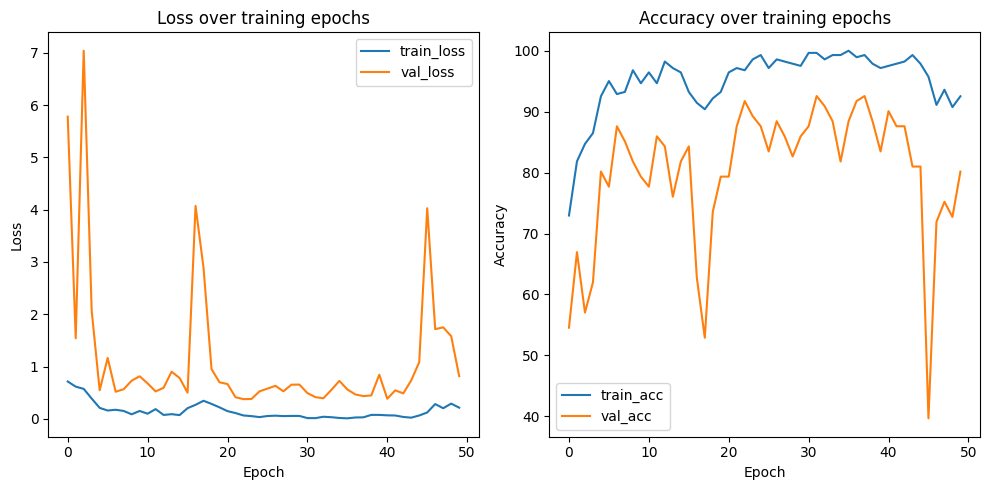

In [22]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the training and validation loss
axs[0].plot(history[1]['train_loss'], label='train_loss')
axs[0].plot(history[1]['val_loss'], label='val_loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss over training epochs')
axs[0].legend()

# Plot the training and validation accuracy
axs[1].plot(history[1]['train_acc'], label='train_acc')
axs[1].plot(history[1]['val_acc'], label='val_acc')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy over training epochs')
axs[1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

In [23]:
# show the save paths from history
history

({'val_loss_min': 0.376969542631433,
  'val_loss_epoch': 23,
  'val_acc_max': 92.56198347107438,
  'val_acc_epoch': 38},
 {'n_epochs': 50,
  'train_loss': [0.7143970766101444,
   0.6161919777079409,
   0.5732216487151448,
   0.38831400319774806,
   0.20971675662595607,
   0.1594590668125721,
   0.17397946050370716,
   0.15140966068807446,
   0.0872033075081496,
   0.15136106474676378,
   0.09851572586362685,
   0.18637249255519744,
   0.0748414281768943,
   0.08971735540764188,
   0.07178668850482677,
   0.20442764423920168,
   0.26854965308170725,
   0.34595215585732375,
   0.2859560946446721,
   0.22009265303505698,
   0.1477946141648547,
   0.11087120894435462,
   0.0646486203733076,
   0.052168748769047424,
   0.0337610574061336,
   0.05436979451637675,
   0.06083793163935909,
   0.05276371098498008,
   0.056247281116098696,
   0.05610751564816648,
   0.014671237023590378,
   0.01383115711279737,
   0.040262433411918076,
   0.03163402999529211,
   0.017219141390824234,
   0.0099313

save the data to azure cosmos NoSQL database


In [24]:
# local_saved_path= list(history[2].values())[0]
# model_file_name_loss = list(history[2].values())[1]
# print(f'{list(history[2].values())[0]}/{list(history[2].values())[1]}')

# model_file_name_loss= f'{list(history[2].values())[0]}/{list(history[2].values())[1]}'
# print(model_file_name_loss)

# Azure Cosmos NoSQL db seems to refuse the size of the model file.

In [25]:
# # save the model to cosmos db


# import time

# model_file_name_loss= f'../{list(history[2].values())[0]}/{list(history[2].values())[1]}'
# model_file_name_acc = f'../{list(history[2].values())[0]}/{list(history[2].values())[2]}'
# model_file_name_final = f'../{list(history[2].values())[0]}/{list(history[2].values())[3]}'
# # model_file_name_loss= './20230605-103225_pinky_loss.pt' 
# # model_file_name_acc = './20230605-103225_pinky_acc.pt'
# # model_file_name_final = './20230605-103225_pinky_final.pt'
# print(model_file_name_loss)
# print(model_file_name_acc)
# print(model_file_name_final)


# pulled_loss = cf.save_data(parameters, history, )
# time.sleep(2)
# pulled_acc = cf.save_data(parameters, history)
# time.sleep(2)
# pulled_final = cf.save_data(parameters, history)

test


In [26]:
# function to test the model
def test_model(model, datasetPath):
    model.eval()    


    # Load the test dataset
    dataset_path = datasetPath
    transform = T.Compose([
        T.Resize((128, 128)),
        T.ToTensor()
                
])
    
    #pull the relevant AQL data
    AQLtest = MyAQLclass()
    lotsize = AQLtest.get_lotsize()
    test_inspection_lvl = AQLtest.get_test_inspection_lvl()
    batch_size = AQLtest.batch_size()

    dataset = ImageFolder(dataset_path, transform=transform)
    test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    labels_dict = dataset.class_to_idx

    # Track the overall test accuracy and accuracy by each type of apple
    overall_correct = 0
    overall_total = 0
    normal_correct = 0
    normal_total = 0
    abnormal_correct = 0
    abnormal_total = 0

    # Initialize the confusion matrix
    num_classes = len(labels_dict)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

    # Iterate over the test dataset
    # Iterate over the test dataset
    for batch_idx, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)

        # Update accuracy counts
        overall_correct += (predicted == labels).sum().item()
        overall_total += labels.size(0)

        # Calculate accuracy for normal apples vs. abnormal apples
        normal_mask = labels == labels_dict['Normal_Apple']
        abnormal_mask = ~normal_mask
        normal_correct += (predicted[normal_mask] == labels[normal_mask]).sum().item()
        normal_total += normal_mask.sum().item()
        abnormal_correct += (predicted[abnormal_mask] == labels[abnormal_mask]).sum().item()
        abnormal_total += abnormal_mask.sum().item()

        # Update the confusion matrix
        for true_label, predicted_label in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
            confusion_matrix[true_label][predicted_label] += 1
        
        # Break the loop after processing the first batch
        if batch_idx == 0:
            break

    # Calculate overall accuracy
    overall_accuracy = overall_correct / overall_total

    # Calculate accuracy for normal apples and abnormal apples separately
    normal_accuracy = normal_correct / normal_total if normal_total != 0 else 0.0
    abnormal_accuracy = abnormal_correct / abnormal_total if abnormal_total != 0 else 0.0

    # Print overall accuracy
    print(f"Overall accuracy: {overall_accuracy:.4f}")

    # Print accuracy for normal apples and abnormal apples separately
    print(f"Normal Apple accuracy: {normal_accuracy:.4f}")
    print(f"Abnormal Apple accuracy: {abnormal_accuracy:.4f}")

    # Print the confusion matrix
    print()
    print(labels_dict)
    print("Confusion Matrix:")
    print(confusion_matrix)

  

    # get the AQL label
    rejected_apples = np.sum(confusion_matrix)-np.sum(confusion_matrix[1])
    
    
    AQLtest.test_input = rejected_apples
    x=AQLtest.output()
    
    print(f'From a lot of {lotsize} in accordance quality level {test_inspection_lvl},')
    print(f'a batch of {batch_size} has been randomly drawn.')
    print(f'the number of rejected apples is: {rejected_apples}')
    print(f'The AQL label is: Class_{x}')


In [27]:
print(pulled_final)

NameError: name 'pulled_final' is not defined

# WIP loader loads a wrong data type.